Bayesian Neural Network model traning and prediction data generation.

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import pickle

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from scipy.stats import norm

Load the training databases, generated in player_match_database_creation

In [3]:
db1 = pd.read_excel('mid_outputs/database_entries.xlsx', index_col = 0)   
db2 = pd.read_excel('mid_outputs/season2021/database_entries.xlsx', index_col = 0)   
db3 = pd.read_excel('mid_outputs/season2122/database_entries.xlsx', index_col = 0)   
db4 = pd.read_excel('mid_outputs/season2223/database_entries.xlsx', index_col = 0)   

In [4]:
db = pd.concat([db1, db2, db3, db4], ignore_index = True) 

db

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,miscontrols,dispossessed,fouls,fouled,aerials_won,aerials_lost,carries,progressive_carries,carries_into_final_third,carries_into_penalty_area
0,1,Zappacosta,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,0.020161,0.012097,0.012097,0.016129,0.008065,0.016129,0.391129,0.040323,0.020161,0.012097
1,1,Djimsiti,Atalanta,Sassuolo,0,6.0,0,0,0.0,6.0,...,0.007874,0.000000,0.007874,0.000000,0.019685,0.027559,0.350394,0.000000,0.000000,0.000000
2,1,Kolasinac,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,0.002786,0.002786,0.002786,0.011142,0.013928,0.022284,0.412256,0.019499,0.025070,0.002786
3,1,Zortea,Atalanta,Sassuolo,0,7.0,1,0,0.0,10.0,...,0.000000,0.020833,0.031250,0.000000,0.000000,0.010417,0.447917,0.062500,0.041667,0.010417
4,1,Ruggeri,Atalanta,Sassuolo,0,6.5,0,1,0.0,7.5,...,0.012384,0.003096,0.012384,0.006192,0.003096,0.027864,0.408669,0.015480,0.012384,0.003096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30064,38,Miguel Veloso,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.006019,0.006019,0.017197,0.006879,0.012038,0.012038,0.265692,0.014617,0.011178,0.000860
30065,38,Tameze,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.012867,0.011217,0.010558,0.010228,0.008908,0.010228,0.235236,0.010558,0.011217,0.001320
30066,38,Sulemana I.,Verona,Milan,0,6.0,0,0,0.5,5.5,...,0.015361,0.013825,0.016897,0.004608,0.015361,0.018433,0.201229,0.006144,0.010753,0.000000
30067,38,Djuric,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.019034,0.010981,0.017570,0.021230,0.144217,0.041728,0.191801,0.001464,0.003660,0.002196


In [5]:
db_gk1 = pd.read_excel('mid_outputs/database_entries_gk.xlsx', index_col = 0)   
db_gk2 = pd.read_excel('mid_outputs/season2021/database_entries_gk.xlsx', index_col = 0)   
db_gk3 = pd.read_excel('mid_outputs/season2122/database_entries_gk.xlsx', index_col = 0)   
db_gk4 = pd.read_excel('mid_outputs/season2223/database_entries_gk.xlsx', index_col = 0)   

db_gk = pd.concat([db_gk1, db_gk2, db_gk3, db_gk4], ignore_index = True) 

db_gk

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,gk_psxg,gk_psnpxg_per_shot_on_target_against,gk_psxg_net,gk_passes_completed_launched,gk_passes_launched,gk_passes,gk_passes_throws,gk_goal_kicks,gk_crosses,gk_crosses_stopped
0,1,Musso,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,2.100000,0.210000,0.100000,11.000000,34.000000,88.000000,18.000000,18.000000,28.000000,2.000000
1,1,Skorupski,Bologna,Milan,1,6.0,-2,0,0.0,4.0,...,3.200000,0.320000,-0.800000,17.000000,45.000000,106.000000,17.000000,22.000000,57.000000,2.000000
2,1,Radunovic,Cagliari,Torino,0,6.5,0,0,0.0,6.5,...,4.100000,0.330000,0.100000,24.000000,54.000000,76.000000,18.000000,40.000000,62.000000,4.000000
3,1,Caprile,Empoli,Verona,1,5.0,-1,0,0.0,4.0,...,0.400000,0.110000,-0.600000,4.000000,20.000000,37.000000,9.000000,4.000000,10.000000,2.000000
4,1,Terracciano,Fiorentina,Genoa,0,6.0,-1,0,0.0,5.0,...,1.000000,0.170000,-2.000000,13.000000,20.000000,85.000000,10.000000,9.000000,16.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,38,Russo A.,Sassuolo,Fiorentina,1,5.0,-3,0,0.0,2.0,...,32.550000,0.325000,-12.116667,146.666667,365.333333,957.000000,156.166667,238.833333,391.500000,23.333333
2365,38,Zoet,Spezia,Roma,0,5.5,-2,0,0.5,3.0,...,10.016667,0.158333,-1.816667,46.000000,145.333333,254.166667,37.333333,51.833333,130.333333,5.500000
2366,38,Milinkovic-Savic V.,Torino,Inter,1,5.0,-1,0,0.0,4.0,...,35.800000,0.230000,-5.200000,285.000000,939.000000,1506.000000,185.000000,286.000000,469.000000,36.000000
2367,38,Silvestri,Udinese,Juventus,1,6.5,-1,0,0.0,5.5,...,48.700000,0.310000,2.700000,144.000000,380.000000,872.000000,142.000000,302.000000,547.000000,13.000000


Load player stats from current season and past seasons

In [6]:
players_orig = pd.read_excel('mid_outputs/players_stats.xlsx', index_col = 3)
#players = pd.read_excel('mid_outputs/players_stats_rwk.xlsx', index_col = 3) # reworked stats to account for past season

players_old = pd.read_excel('mid_outputs/season2223/players_stats.xlsx', index_col = 3)
players_old_2 = pd.read_excel('mid_outputs/season2122/players_stats.xlsx', index_col = 3)
players_old_3 = pd.read_excel('mid_outputs/season2021/players_stats.xlsx', index_col = 3)

players = players_orig

Load team data from current season and add an average Serie A team row

In [7]:
team_data = pd.read_excel('mid_outputs/team_data.xlsx', index_col = 0)

avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)
avg_row['team']['Avg'] = 'Avg'

team_data = pd.concat([team_data, avg_row])

team_data

C:\Users\nicol\AppData\Local\Temp\ipykernel_5452\661405348.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)


,team,team_players_used,team_possession,team_games,team_games_starts,team_minutes,team_goals,team_assists,team_pens_made,team_pens_att,...,vs_team_fouls,vs_team_fouled,vs_team_offsides,vs_team_pens_won,vs_team_pens_conceded,vs_team_own_goals,vs_team_ball_recoveries,vs_team_aerials_won,vs_team_aerials_lost,vs_team_aerials_won_pct
Atalanta,Atalanta,23.00,49.500,4.0,44.0,360.0,8.00,8.00,0.00,0.0,...,36.0,47.0,2.0,0.0,0.0,0.00,212.00,65.0,60.0,52.00
Bologna,Bologna,22.00,56.500,4.0,44.0,360.0,3.00,2.00,0.00,1.0,...,50.0,40.0,12.0,0.0,1.0,0.00,207.00,34.0,46.0,42.50
Cagliari,Cagliari,21.00,37.800,4.0,44.0,360.0,1.00,1.00,0.00,0.0,...,38.0,41.0,5.0,0.0,0.0,0.00,220.00,60.0,51.0,54.10
Empoli,Empoli,27.00,47.800,4.0,44.0,360.0,0.00,0.00,0.00,0.0,...,60.0,42.0,8.0,1.0,0.0,0.00,203.00,54.0,39.0,58.10
Fiorentina,Fiorentina,22.00,61.000,4.0,44.0,360.0,9.00,7.00,0.00,0.0,...,56.0,43.0,5.0,1.0,0.0,0.00,202.00,56.0,53.0,51.40
Frosinone,Frosinone,23.00,48.300,4.0,44.0,360.0,7.00,4.00,2.00,2.0,...,50.0,39.0,6.0,0.0,2.0,0.00,212.00,53.0,52.0,50.50
Genoa,Genoa,19.00,33.300,4.0,44.0,360.0,4.00,3.00,0.00,0.0,...,43.0,43.0,9.0,0.0,0.0,0.00,200.00,46.0,60.0,43.40
Verona,Hellas Verona,21.00,43.500,4.0,44.0,360.0,4.00,2.00,0.00,0.0,...,47.0,63.0,7.0,1.0,0.0,0.00,190.00,71.0,82.0,46.40
Inter,Inter,19.00,48.800,4.0,44.0,360.0,13.00,11.00,2.00,2.0,...,47.0,44.0,5.0,0.0,2.0,0.00,163.00,30.0,44.0,40.50
Juventus,Juventus,21.00,48.800,4.0,44.0,360.0,9.00,7.00,1.00,2.0,...,52.0,49.0,5.0,0.0,2.0,0.00,173.00,26.0,38.0,40.60


Data processing functions copied from player_match_dataset_creation

In [8]:
features_abs = ['r',
 'games',
 'games_starts',                
 'minutes',
 'shots_on_target_pct',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'passes_pct',
 #'dribble_tackles_pct',
 #'dribbles_completed_pct',
 'aerials_won_pct',
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel = [
 'goals',
 'assists',
 'cards_yellow',
 'cards_red',
 'xg',
 'npxg',
 'shots_on_target',
 'passes_completed',
 'passes_into_final_third',
 'passes_into_penalty_area',
 'progressive_passes',
 'passes_live',
 'passes_dead',
 'through_balls',
 'passes_switches',
 'crosses',
 'corner_kicks',
 #'dribble_tackles',
 #'dribbles_vs',
 #'dribbled_past',
 'blocks',
 'blocked_shots',
 'blocked_passes',
 'interceptions',
 'clearances',
 'errors',
 'touches',
 'touches_def_pen_area',
 'touches_def_3rd',
 'touches_mid_3rd',
 'touches_att_3rd',
 'touches_att_pen_area',
 'touches_live_ball',
 #'dribbles_completed',
 #'dribbles',
 'passes_received',
 'miscontrols',
 'dispossessed',
 'fouls',
 'fouled',
 'aerials_won',
 'aerials_lost',
 'carries',
 'progressive_carries',
 'carries_into_final_third',
 'carries_into_penalty_area']

features_rel_gamecorr = [
    'goals',
    'assists',
    'xg',
    'npxg',
    'cards_yellow',
    'cards_red'
]

In [9]:
features_abs_gk = [
 'gk_games',
 'gk_games_starts',
 'gk_minutes',
 'gk_goals_against_per90', 
 'gk_save_pct',
 'gk_clean_sheets_pct',
 'gk_psxg_net_per90',
 'gk_passes_pct_launched',
 'gk_pct_passes_launched',
 'gk_passes_length_avg',
 'gk_pct_goal_kicks_launched',
 'gk_goal_kick_length_avg',
 'gk_crosses_stopped_pct',
 'gk_def_actions_outside_pen_area_per90',
 'gk_avg_distance_def_actions',
    
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel_gk = [
 'gk_shots_on_target_against',
 'gk_saves',
 'gk_free_kick_goals_against',
 'gk_corner_kick_goals_against',
 'gk_own_goals_against',
 'gk_psxg',
 'gk_psnpxg_per_shot_on_target_against',
 'gk_psxg_net',
 'gk_passes_completed_launched',
 'gk_passes_launched',
 'gk_passes',
 'gk_passes_throws',
 'gk_goal_kicks',
 'gk_crosses',
 'gk_crosses_stopped',
]

In [10]:
DEL_G = False

features_to_del = [
    'goals',
    'assists',
    'xg',
    'npxg'
]

def player_match_data(player, pteam, oppteam, oldseason = False):
    if(not(player in players.index)):
        return None
    
    if(oldseason):
        pdata = players_old.loc[[player]]
    else:
        pdata = players.loc[[player]]
    
    pteam_stats = team_data.loc[[pteam]].rename(index = {pteam : player})
    
    oppteam_stats = team_data.loc[[oppteam]].rename(index = {oppteam : player})
    
    oppteam_stats = oppteam_stats.rename(lambda x: 'opp_' + x, axis='columns')
    
    out = pd.concat([pdata, pteam_stats, oppteam_stats], axis = 1)
    
    return(out)

def player_match_data_ext(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    assert pdata['games'][0] > 0
        
    out = pd.concat([pdata[features_abs], pdata[features_rel]], axis = 1)
    
    out[features_rel] = out[features_rel] / max(pdata['minutes'][0], 1)
    
    out[features_rel_gamecorr] = out[features_rel_gamecorr] * (pdata['minutes'][0] / max(pdata['games'][0], 1) / 90)
    
    if(DEL_G):
        out[features_to_del] = 0
    
    return out

def player_match_data_ext_gk(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    if(pdata['gk_games'][0] <= 0):
        return None
    
    out = pd.concat([pdata[features_abs_gk], pdata[features_rel_gk]], axis = 1)
    
    out[features_rel_gk] = out[features_rel_gk] / max(pdata['minutes'][0], 1)

    return out
    

Load data from previous seasons in other leagues, for new players (rookies) in Serie A

In [11]:
rookies_data = pd.read_excel('rookies_stats/out_data/rookies_stats.xlsx', index_col = 1)

rookies_data

,Unnamed: 0,nationality,position,team,team.1,age,birth_year,games,games_starts,minutes,...,vs_team_pens_conceded,vs_team_own_goals,league,season,surname,initial,name,vote_avg,vote_std,r
player,,,,,,,,,,,,,,,,,,,,,
Kolasinac,0,ba BIH,DF,Marseille,Marseille,29,1993,33,26,2214,...,7,6,Ligue-1,2022-2023,Kolasinac,S,Sead Kolašinac,6,0.3,D
Freuler,1,ch SUI,MF,Nott'ham Forest,Nott'ham Forest,30,1992,28,24,2161,...,6,2,Premier-League,2022-2023,Freuler,R,Remo Freuler,6,0.3,C
Karlsson,2,se SWE,FW,AZ Alkmaar,AZ Alkmaar,24,1998,23,21,1777,...,3,3,Eredivisie,2022-2023,Karlsson,J,Jesper Karlsson,6,0.3,A
Kristiansen,3,dk DEN,DF,Leicester City,Leicester City,19,2002,12,11,892,...,6,2,Premier-League,2022-2023,Kristiansen,V,Victor Bernth Kristiansen,6,0.3,D
Mina,4,co COL,DF,Everton,Everton,27,1994,7,7,594,...,2,2,Premier-League,2022-2023,Mina,Y,Yerry Mina,6,0.3,D
Monterisi,5,it ITA,DF,Frosinone,Frosinone,20,2001,11,6,615,...,0,2,Serie-B,2022-2023,Monterisi,I,Ilario Monterisi,6,0.3,D
Pavard,6,fr FRA,DF,Bayern Munich,Bayern Munich,26,1996,30,27,2431,...,5,2,Bundesliga,2022-2023,Pavard,B,Benjamin Pavard,6,0.3,D
Thuram,7,fr FRA,FW,M'Gladbach,M'Gladbach,24,1997,30,28,2513,...,6,0,Bundesliga,2022-2023,Thuram,M,Marcus Thuram,6,0.3,A
Klaassen,8,nl NED,MF,Ajax,Ajax,29,1993,33,21,2046,...,5,0,Eredivisie,2022-2023,Klaassen,D,Davy Klaassen,6,0.3,C


Players stats rework:
the current season stats are averaged (according to a calculated weight) with the past season data.
In case a player doesn't have past season data, a config file (affine_players) can be used to load the data from an affine player (past season), e.g. Doig affine to Lazovic.
In case, after this process, the player doesn't result in having a minimum amount of games, its stats are averaged with the average Serie A (defensive) player stat, depending on the games remaining to reach the minimum amount. This allows to use players who still haven't played a single game.

These modified stats are used only for prediction, not for model traning.

WEIGHT_0 = weight given to the current season in respect to the previous; if the player has a low amount of games this season, the weight is lowered
min_games = minimum games so that the players stats are not averaged with the avg Serie A player stats

In [41]:
#for i in range(players.columns.shape[0]):
#    print(str(i) + ' - ' + players.columns[i])

cols_toadapt = players.columns[9:]
cols_toadapt_rookies = rookies_data.columns.intersection(cols_toadapt)

players = players_orig.copy()

min_games = 6

current_season_games = max(10, max(players_orig['games']))

# weight_0 as function of current_season_games --> 1 as match day reachs 30 ? 
WEIGHT_0_same_team = (1 - (1 - 0.7) * (30 - current_season_games) / (38 - 12)) # 0.7
WEIGHT_0_different_team = (1 - (1 - 0.75) * (30 - current_season_games) / (38 - 12)) # 0.75
WEIGHT_mul_gk = 2

rcsv = pd.read_csv('config/affine_players.txt')   
affine_players = pd.DataFrame(rcsv)
affine_players = affine_players.set_index('player')


def calc_weight(games_curr, games_old, same_team = 1, maxgames = current_season_games):
    if(same_team):
        weight_0 = WEIGHT_0_same_team
    else:
        weight_0 = WEIGHT_0_different_team

    weight = weight_0 * (games_curr / maxgames) / (max(games_old, 1) / 38)
    weight = min(weight, 1)

    return abs(weight)

print(' ')
print('Averaging players stats with past seasons:')


for i in range(players.shape[0]):
    p = players.index[i]
    

    if(p in players_old.index or p in affine_players.index):
        p_ = p
        affine = 0
        
        if(p in affine_players.index):
            affine = 1
            p_ = affine_players.loc[p]['alike']
            
            print(p + ' affine to ' + p_)
        
        if(players.loc[p]['r'] == 'P'):
            weight = calc_weight(players.loc[p]['gk_games'], players_old.loc[p_]['gk_games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])
            weight *= WEIGHT_mul_gk
            weight = min(weight, 1)
        else:
            weight = calc_weight(players.loc[p]['games'], players_old.loc[p_]['games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])

        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old.loc[p_][cols_toadapt])
        
        print(p + ' ' + str(weight))     
    elif(p in rookies_data.index):
        p_ = p
        weight = calc_weight(players.loc[p]['games'], rookies_data.loc[p_]['games'], False)
        players.at[p, cols_toadapt_rookies] = (players.loc[p][cols_toadapt_rookies] * weight + (1-weight) * rookies_data.loc[p_][cols_toadapt_rookies])
        
        print(p + ' ' + str(weight) + ' (rookie)')     

    
    # to handle players like Scamacca, who only played 2 seasons ago; only outfield players
    if(players.loc[p]['r'] != 'P' and players.loc[p]['games'] < min_games and p in players_old_2.index):    
        weight = calc_weight(players.loc[p]['games'], players_old_2.loc[p]['games'], players.loc[p]['team'] == players_old_2.loc[p]['team'])
        
        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old_2.loc[p][cols_toadapt])
        
        print(p + ' ' + str(weight) + ' (two seasons ago)')
    
    
# handle players with low quantitites of games

print('Players with low quantity of games:')

def calc_weight_low(current_games, min_games = min_games):
    weight = 1 - (min_games - current_games)/min_games
    
    weight = min(weight, 1)

    return abs(weight)

#mean_players_stats = players_orig[players_orig['games'] >= min_games][cols_toadapt].mean()


# mean players stats based on old season

mean_players_stats = players_orig.loc[players_orig.index[0]][cols_toadapt] * 0
count = 0

for i in range(players_old.shape[0]):
    if(players_old['games'][i] >= min_games and (players_old['r'][i] == 'D')): # counting only defenders, to add a penalty
        mean_players_stats += players_old.loc[players_old.index[i]][cols_toadapt]
        count = count + 1
        
mean_players_stats /= count

for i in range(players.shape[0]):
    p = players.index[i]
    
    if(players.loc[p]['games'] < min_games and players.loc[p]['r'] != 'P'):
        weight = calc_weight_low(players.loc[p]['games'])
        
        players.at[p, cols_toadapt] = players.loc[p][cols_toadapt] * weight + (1-weight) * mean_players_stats
        
        print(p + ' ' + str(weight))
        
        
players_out = players.copy()
players_out = players_out.set_index(players_out.columns[0])
players_out.insert(2, 'name', players_out.index)
players_out.to_excel('mid_outputs/players_stats_rwk.xlsx')


 
Averaging players stats with past seasons:
Szczesny 0.41758241758241765
Meret 0.6877828054298643
Provedel 0.6153846153846154
Maignan 1
Rui Patricio 0.6681318681318682
Skorupski 0.632016632016632
Milinkovic-Savic V. 0.6153846153846154
Di Gregorio 0.47401247401247393
Falcone 0.6153846153846154
Silvestri 0.6153846153846154
Terracciano 0.40318302387267907
Carnesecchi 0.22735042735042738
Montipo' 0.632016632016632
Ochoa 1
Consigli 0.501098901098901
Musso 0.7307692307692307
Cragno 1
Perin 1
Berisha 1
Sportiello 1
Mirante 1
Sepe 1
Lamanna 1
Pegolo 1
Perilli 1
Padelli 1
Gollini 1
Perisan 0.8351648351648353
Audero 0.9821538461538462
Pinsoglio 1
Fiorillo 1
Cerofolini 1
Rossi F. 1
Ravaglia F. 1
Brancolini 1
Berardi A. 1
Gemello 1
Boer 1
Bagnolini 1
Svilar 1
Sorrentino A. 1
Dimarco 0.3543123543123543
Di Lorenzo 0.316008316008316
Hernandez T. 0.3653846153846154
Carlos Augusto 0.3507692307692308
Danilo 0.316008316008316
Zappacosta 0.5567765567765568
Schuurs 0.38974358974358975
Posch 0.389743589743

Rog 0.0 (two seasons ago)
Nicolussi Caviglia 0.0
Demme 0.0
Pafundi 0.0
Adli 0.0
Zerbin 0.2923076923076923
Carboni V. 1
Faticanti 0.0
Osimhen 0.3653846153846154
Martinez L. 0.3076923076923077
Rafael Leao 0.3340659340659341
Lukaku 0.24553846153846154
Berardi 0.22485207100591717
Immobile 0.3771712158808933
Vlahovic 0.4330484330484331
Dybala 0.23384615384615384
Kvaratskhelia 0.25791855203619907
Giroud 0.3543123543123543
Scamacca 0.3410256410256411 (two seasons ago)
Thuram 0.40923076923076923 (rookie)
Lookman 0.3771712158808933
Dia 0.17715617715617715
Arnautovic 0.5846153846153845
Retegui 0.5846153846153845 (rookie)
Sanabria 0.17715617715617715
Nzola 0.396029776674938
Lauriente' 0.41758241758241765
Zapata D. 0.24553846153846154
Chiesa 0.5567765567765568
Milik 0.4330484330484331
Gonzalez N. 0.4871794871794872
Pinamonti 0.3653846153846154
Beltran L. 0.4910769230769231 (rookie)
Caprari 0.316008316008316
Sanchez 0.0 (rookie)
Caputo 0.5567765567765568
Belotti 0.3771712158808933
Muriel 0.20159151

In [15]:
players.columns[9:]

Index(['games', 'games_starts', 'minutes', 'goals', 'assists', 'pens_made',
       'pens_att', 'cards_yellow', 'cards_red', 'goals_per90',
       ...
       'gk_pct_goal_kicks_launched', 'gk_goal_kick_length_avg', 'gk_crosses',
       'gk_crosses_stopped', 'gk_crosses_stopped_pct',
       'gk_def_actions_outside_pen_area',
       'gk_def_actions_outside_pen_area_per90', 'gk_avg_distance_def_actions',
       'vote_avg', 'vote_std'],
      dtype='object', length=151)

In [16]:
for i in range(db.columns.shape[0]):
    print(str(i) + " - " + str(db.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - r
11 - games
12 - games_starts
13 - minutes
14 - shots_on_target_pct
15 - goals_per_shot
16 - goals_per_shot_on_target
17 - passes_pct
18 - aerials_won_pct
19 - team_possession
20 - team_goals_assists_per90
21 - team_goals_pens_per90
22 - team_goals_assists_pens_per90
23 - team_xg_per90
24 - team_gk_goals_against_per90
25 - team_gk_save_pct
26 - team_gk_clean_sheets_pct
27 - team_passes_pct
28 - team_passes_pct_medium
29 - team_passes_pct_long
30 - team_sca_per90
31 - team_gca_per90
32 - team_aerials_won_pct
33 - vs_team_possession
34 - vs_team_goals_per90
35 - vs_team_assists_per90
36 - vs_team_xg_per90
37 - vs_team_gk_save_pct
38 - vs_team_gk_clean_sheets_pct
39 - vs_team_gk_pct_passes_launched
40 - vs_team_gk_crosses_stopped_pct
41 - vs_team_shots_on_target_per90
42 - vs_team_passes_pct
43 - vs_team_passes_pct_short
44 - vs_team_passes_pct_medium
45 - vs_team_passe

Elaborate databases data to have X and y for training, and split into a train test and a validation test.

For outfield players: X -> y = [vote, fantavote]

For goalkeepers: X -> y = [vote, fantavote, clean sheet probability]

In [17]:
npdb = np.array(db)

y = npdb[:, [5,9]] # vote, fantavote

#y[:, 1] = y[:, 1] - y[:, 0] # target = difference between fantavote and vote

f_start = 14

X = npdb[:, f_start:]

if(DEL_G): 
    del_g_idx = [
        list(db.columns).index('goals.1') - f_start,
        list(db.columns).index('assists.1') - f_start,
        list(db.columns).index('xg') - f_start,
        list(db.columns).index('npxg') - f_start,
        list(db.columns).index('shots_on_target') - f_start]
    
    X[:, del_g_idx] = 0


# add role and home factor
toadd = np.zeros((X.shape[0], 4))
toadd[:, 0] = npdb[:, 4] # home

toadd[:, 1] = npdb[:, 10] == 'D'
toadd[:, 2] = npdb[:, 10] == 'C'
toadd[:, 3] = npdb[:, 10] == 'A'

X = np.concatenate((X, toadd), axis = 1)



In [18]:
scaler = StandardScaler()
scaler.fit(X)

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [19]:
for i in range(db_gk.columns.shape[0]):
    print(str(i) + " - " + str(db_gk.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - gk_games
11 - gk_games_starts
12 - gk_minutes
13 - gk_goals_against_per90
14 - gk_save_pct
15 - gk_clean_sheets_pct
16 - gk_psxg_net_per90
17 - gk_passes_pct_launched
18 - gk_pct_passes_launched
19 - gk_passes_length_avg
20 - gk_pct_goal_kicks_launched
21 - gk_goal_kick_length_avg
22 - gk_crosses_stopped_pct
23 - gk_def_actions_outside_pen_area_per90
24 - gk_avg_distance_def_actions
25 - team_possession
26 - team_goals_assists_per90
27 - team_goals_pens_per90
28 - team_goals_assists_pens_per90
29 - team_xg_per90
30 - team_gk_goals_against_per90
31 - team_gk_save_pct
32 - team_gk_clean_sheets_pct
33 - team_passes_pct
34 - team_passes_pct_medium
35 - team_passes_pct_long
36 - team_sca_per90
37 - team_gca_per90
38 - team_aerials_won_pct
39 - vs_team_possession
40 - vs_team_goals_per90
41 - vs_team_assists_per90
42 - vs_team_xg_per90
43 - vs_team_gk_save_pct
44 - vs_team_

In [20]:
npdb_gk= np.array(db_gk)

y_gk = npdb_gk[:, [5,9,6]] # vote, fantavote, goals == 0 (clean sheet)
y_gk[:, 2] = (y_gk[:, 2] == 0) * 1

f_start_gk = 13

X_gk = npdb_gk[:, f_start_gk:]

# add home factor
toadd_gk = np.zeros((X_gk.shape[0], 1))
toadd_gk[:, 0] = npdb_gk[:, 4] # home

X_gk = np.concatenate((X_gk, toadd_gk), axis = 1)



In [21]:
scaler_gk = StandardScaler()
scaler_gk.fit(X_gk)

X_gk_train_, X_gk_test_, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = 0.2, random_state = 18)

X_gk_train = scaler_gk.transform(X_gk_train_)
X_gk_test = scaler_gk.transform(X_gk_test_)

MLP Regressor , to see performance of a simple neural network

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.15507286428738876
0.18856961333473798


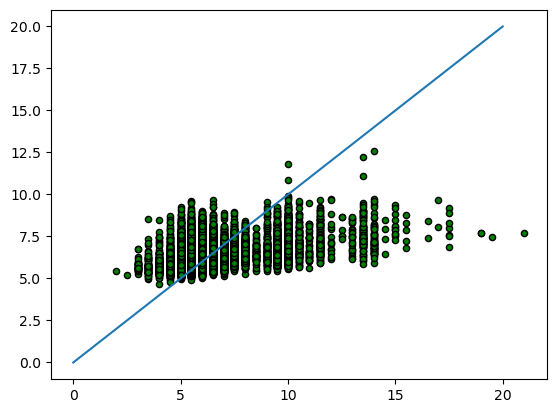

0.1354212153815001
0.17392551015116653


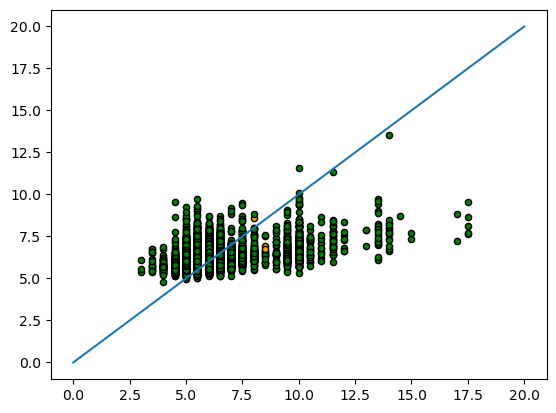

In [19]:
regr = MLPRegressor(max_iter = 400000, solver = 'lbfgs', hidden_layer_sizes = (8, 8), alpha = 500, verbose = True)

regr.fit(X_train, y_train)


y_train_predict = regr.predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))


plt.show()

y_test_predict = regr.predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))


plt.show()

Train neural network for outfield players.

The outputs of the NN are probability distribution of SinhArcsinh type (a skewed distribution, which is a generalization of Gaussian)

In [22]:
load_model_of = True# load scaler and model weights for outfield player predictor
refit_model_of = True

if(load_model_of):
    scaler = pickle.load(open('saves/scaler.pkl', 'rb'))
    
    X_train = scaler.transform(X_train_)
    X_test = scaler.transform(X_test_)


n_epochs = 1000

n_samples = X_train.shape[0]

batch_size = 256

X_len = X_train.shape[1]
y_len = y_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.2


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_len,), name="input")
x = tfk.layers.Dropout(0.2)(inputs)
x = tfk.layers.Dense(16, activation="relu") (x)
x = tfk.layers.Dropout(0.2)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)
x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)


modelb = tf.keras.Model(inputs, [out_1, out_2])

modelb.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_of):
    modelb.load_weights('saves/modelb')
    
if( (not load_model_of) or refit_model_of):
    modelb.fit(X_train.astype('float32'), [y_train[:, 0].astype('float32'), y_train[:, 1].astype('float32')], 
              validation_data = (X_test.astype('float32'), [y_test[:, 0].astype('float32'), y_test[:, 1].astype('float32')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

Epoch 1/1000
94/94 [==============================] - 4s 9ms/step - loss: 2.1251 - distribution_lambda_loss: 0.8284 - distribution_lambda_1_loss: 1.2967 - val_loss: 2.0962 - val_distribution_lambda_loss: 0.8157 - val_distribution_lambda_1_loss: 1.2804
Epoch 2/1000
94/94 [==============================] - 0s 3ms/step - loss: 2.1244 - distribution_lambda_loss: 0.8284 - distribution_lambda_1_loss: 1.2960 - val_loss: 2.1000 - val_distribution_lambda_loss: 0.8174 - val_distribution_lambda_1_loss: 1.2826
Epoch 3/1000
94/94 [==============================] - 0s 3ms/step - loss: 2.1246 - distribution_lambda_loss: 0.8271 - distribution_lambda_1_loss: 1.2976 - val_loss: 2.1027 - val_distribution_lambda_loss: 0.8194 - val_distribution_lambda_1_loss: 1.2832
Epoch 4/1000
94/94 [==============================] - 0s 3ms/step - loss: 2.1244 - distribution_lambda_loss: 0.8265 - distribution_lambda_1_loss: 1.2978 - val_loss: 2.1046 - val_distribution_lambda_loss: 0.8192 - val_distribution_lambda_1_loss:

In [23]:
def sample_predict(X, iterations = 100):
    y = np.zeros((2, X.shape[0]))
    
    dist = modelb(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        
    return y.transpose() / iterations
    

0.14232313843838407
0.16748424431848907


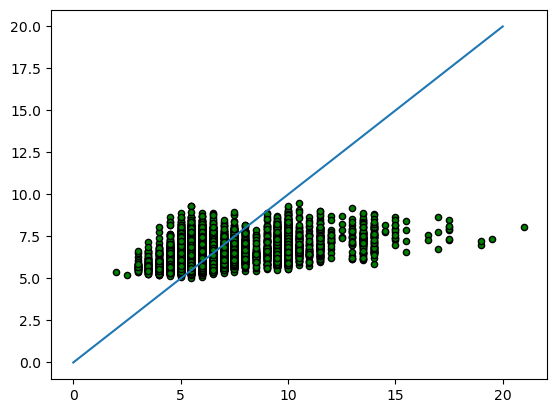

0.13031966791602223
0.15463784705801664


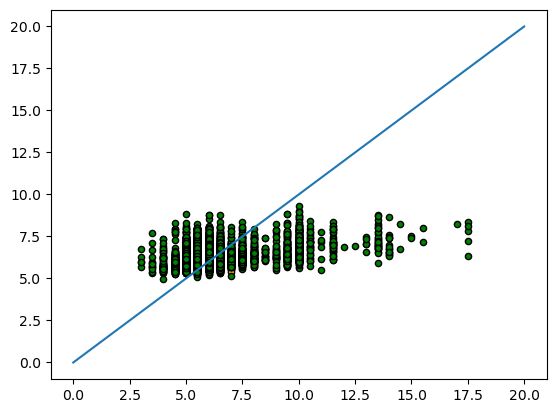

In [24]:
y_train_predict = sample_predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))

plt.show()

y_test_predict = sample_predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))




Train neural network for goalkeepers.

For clean sheet probability prediction, a Bernoulli distribution is used.

In [25]:
load_model_gk = True# load scaler and model weights for goalkeeper player predictor
refit_model_gk = True

if(load_model_gk):
    scaler_gk = pickle.load(open('saves/scaler_gk.pkl', 'rb'))
    
    X_gk_train = scaler_gk.transform(X_gk_train_)
    X_gk_test = scaler_gk.transform(X_gk_test_)
    
    
n_epochs = 2500

n_samples = X_gk_train.shape[0]

batch_size = 128

X_gk_len = X_gk_train.shape[1]
y_gk_len = y_gk_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 0.8


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_gk_len,), name="input")
x = tfk.layers.Dense(16, activation="relu") (inputs)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(16, activation="sigmoid")(x)
x1 = tfk.layers.Dropout(0.2)(x1)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(16, activation="sigmoid")(x)

x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)

x3 = tfk.layers.Dense(8, activation="sigmoid")(x)
x3 = tfk.layers.Dropout(0.2)(x3)
x3 = tfk.layers.Dense(1, activation="sigmoid")(x3)
out_3 = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs = t[..., 0]))(x3)

modelb_gk = tf.keras.Model(inputs, [out_1, out_2, out_3])

modelb_gk.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_gk):
    modelb_gk.load_weights('saves/modelb_gk')

if( (not load_model_gk) or refit_model_gk):    
    modelb_gk.fit(X_gk_train.astype('float32'), [y_gk_train[:, 0].astype('float32'), y_gk_train[:, 1].astype('float32'), y_gk_train[:, 2].astype('int')], 
              validation_data = (X_gk_test.astype('float32'), [y_gk_test[:, 0].astype('float32'), y_gk_test[:, 1].astype('float32'), y_gk_test[:, 2].astype('int')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

Epoch 1/2500
15/15 [==============================] - 4s 51ms/step - loss: 2.9275 - distribution_lambda_2_loss: 0.8261 - distribution_lambda_3_loss: 1.6128 - distribution_lambda_4_loss: 0.4886 - val_loss: 2.7835 - val_distribution_lambda_2_loss: 0.7798 - val_distribution_lambda_3_loss: 1.5644 - val_distribution_lambda_4_loss: 0.4393
Epoch 2/2500
15/15 [==============================] - 0s 4ms/step - loss: 2.9398 - distribution_lambda_2_loss: 0.8407 - distribution_lambda_3_loss: 1.6118 - distribution_lambda_4_loss: 0.4873 - val_loss: 2.7933 - val_distribution_lambda_2_loss: 0.7822 - val_distribution_lambda_3_loss: 1.5676 - val_distribution_lambda_4_loss: 0.4435
Epoch 3/2500
15/15 [==============================] - 0s 4ms/step - loss: 2.8995 - distribution_lambda_2_loss: 0.8200 - distribution_lambda_3_loss: 1.6036 - distribution_lambda_4_loss: 0.4760 - val_loss: 2.7982 - val_distribution_lambda_2_loss: 0.7802 - val_distribution_lambda_3_loss: 1.5689 - val_distribution_lambda_4_loss: 0.44

15/15 [==============================] - 0s 4ms/step - loss: 2.8800 - distribution_lambda_2_loss: 0.8125 - distribution_lambda_3_loss: 1.5979 - distribution_lambda_4_loss: 0.4696 - val_loss: 2.8146 - val_distribution_lambda_2_loss: 0.7762 - val_distribution_lambda_3_loss: 1.5850 - val_distribution_lambda_4_loss: 0.4534
Epoch 26/2500
15/15 [==============================] - 0s 4ms/step - loss: 2.8830 - distribution_lambda_2_loss: 0.8167 - distribution_lambda_3_loss: 1.5947 - distribution_lambda_4_loss: 0.4716 - val_loss: 2.8205 - val_distribution_lambda_2_loss: 0.7832 - val_distribution_lambda_3_loss: 1.5836 - val_distribution_lambda_4_loss: 0.4537
Epoch 27/2500
15/15 [==============================] - 0s 4ms/step - loss: 2.8630 - distribution_lambda_2_loss: 0.7963 - distribution_lambda_3_loss: 1.5963 - distribution_lambda_4_loss: 0.4704 - val_loss: 2.8112 - val_distribution_lambda_2_loss: 0.7702 - val_distribution_lambda_3_loss: 1.5849 - val_distribution_lambda_4_loss: 0.4561
Epoch 28/

15/15 [==============================] - 0s 5ms/step - loss: 2.8551 - distribution_lambda_2_loss: 0.8010 - distribution_lambda_3_loss: 1.5880 - distribution_lambda_4_loss: 0.4661 - val_loss: 2.8160 - val_distribution_lambda_2_loss: 0.7707 - val_distribution_lambda_3_loss: 1.5900 - val_distribution_lambda_4_loss: 0.4553
Epoch 50/2500
15/15 [==============================] - 0s 5ms/step - loss: 2.8654 - distribution_lambda_2_loss: 0.8053 - distribution_lambda_3_loss: 1.5910 - distribution_lambda_4_loss: 0.4690 - val_loss: 2.8198 - val_distribution_lambda_2_loss: 0.7728 - val_distribution_lambda_3_loss: 1.5903 - val_distribution_lambda_4_loss: 0.4567
Epoch 51/2500
15/15 [==============================] - 0s 4ms/step - loss: 2.8573 - distribution_lambda_2_loss: 0.8035 - distribution_lambda_3_loss: 1.5875 - distribution_lambda_4_loss: 0.4663 - val_loss: 2.8156 - val_distribution_lambda_2_loss: 0.7705 - val_distribution_lambda_3_loss: 1.5905 - val_distribution_lambda_4_loss: 0.4547


In [26]:
def sample_predict_gk(X, iterations = 100):
    y = np.zeros((3, X.shape[0]))
    
    dist = modelb_gk(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        y[2, :] += dist[2].sample()
        
    return y.transpose() / iterations


0.0798265190543076
0.29563465147366164


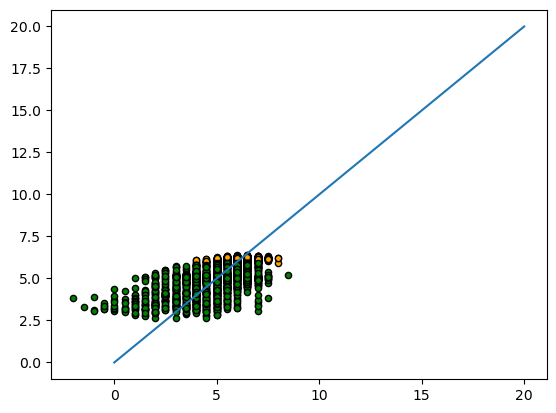

0.02219365253550709
0.159869757007698


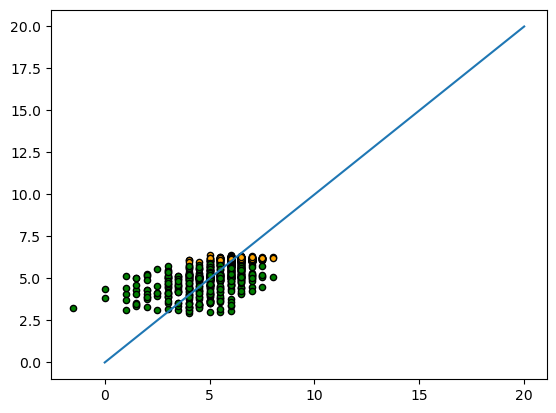

In [27]:
y_gk_train_predict = sample_predict_gk(X_gk_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_train[:, 0], y_gk_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_train[:, 1], y_gk_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_train[:, 0], y_gk_train_predict[:, 0]))
print(r2_score(y_gk_train[:, 1], y_gk_train_predict[:, 1]))

plt.show()

y_gk_test_predict = sample_predict_gk(X_gk_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_test[:, 0], y_gk_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_test[:, 1], y_gk_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_test[:, 0], y_gk_test_predict[:, 0]))
print(r2_score(y_gk_test[:, 1], y_gk_test_predict[:, 1]))




Use the following codes to save the scalers and the model weights

In [28]:
save_model_of = True
save_model_gk = True

if(save_model_of):
    pickle.dump(scaler, open('saves/scaler.pkl', 'wb'))
    modelb.save_weights('saves/modelb')
    
if(save_model_gk):
    pickle.dump(scaler_gk, open('saves/scaler_gk.pkl', 'wb'))
    modelb_gk.save_weights('saves/modelb_gk')
    

Generalized prediction function for a player (playing for team against opp_team, at home or not)

Estimate prediction mean and sigma (using a custom definitions).

Generate a plot.


In [29]:
def vote_predict_NNb(player, team, opp_team, home = 1, plot = 0, log = 0, oldseason = False):
    if(players['r'][player] == 'P'):
        ptest = player_match_data_ext_gk(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 3:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 1))
        xadd[0, 0] = home

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler_gk.transform(x_ptest)

        dist = modelb_gk(x_scaled)
        
        clean_shoot_prob = dist[2].probs.numpy()[0]
    else:
        ptest = player_match_data_ext(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 4:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 4))
        xadd[0, 0] = home
        xadd[0, 1] = r == 'D'
        xadd[0, 2] = r == 'C'
        xadd[0, 3] = r == 'A'

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler.transform(x_ptest)

        dist = modelb(x_scaled)
    
    
    x = np.arange(0, 40, 0.002)

    px1 = dist[0].prob(x);
    px2 = dist[1].prob(x);

    
    #sample1 = dist[0].sample(10000)
    #sample2 = dist[1].sample(10000)
    
    m1 = np.average(x, weights = px1)
    m2 = np.average(x, weights = px2)
    
    #m1 = np.mean(sample1)
    #m2 = np.mean(sample2)
    
    #s1 = np.std(sample1)
    #s2 = np.std(sample2)
      
    # not standard deviation, but expected range extimated by quantile 
    
    if(players['r'][player] == 'P'):
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = -( dist[1].quantile(1 - 0.9) - m2 ) / 2
    else:
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = ( dist[1].quantile(0.9) - m2 ) / 2
    

    
    #y_pred_m = np.array([dist[0].loc, dist[1].loc]).flatten()
    y_pred_m = np.array([m1, m2]).flatten()
    #y_pred_s = np.array([dist[0].scale, dist[1].scale]).flatten()
    y_pred_s = np.array([s1, s2]).flatten()
    
    clean_sheet_text = ''
    if(players['r'][player] == 'P'):
        clean_sheet_text = ' (' + "{:.1f}".format(clean_shoot_prob*100) + '% cs)'
            
    if(plot):
        ax = plt.gca()
        
        plt.plot(x, px1, 
                 label = 'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]),
                color = 'b')
        plt.plot(x, px2, 
                 label = 'FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text,
                color = 'g')
        
        plt.fill_between(x, px1, color = 'lightblue')
        plt.fill_between(x, px2, color = 'lightgreen')
        
        plt.legend()
        
        plt.vlines(x = y_pred_m[0], color = 'b', ymin = 0, ymax = 3, linestyle = 'dashed')
        plt.vlines(x = y_pred_m[1], color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed')
        
        plt.title(player + ' (' + team + ' vs ' + opp_team + ')')
        
        plt.xlim([0, 15])
        
        if(players['r'][player] == 'P'):            
            plt.ylim([0, 2.5])
        else:
            plt.ylim([0, 1.5])
        
        plt.show()
        
    if(log):
        print(player + ': ' + 
         'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]) +
         '; FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text);
    return [y_pred_m, y_pred_s, dist]


Load Serie A calendar. 

In [30]:
cal = np.array(pd.read_excel('fantacalcio/seriea_calendar.xlsx', header = None))

cal_df = pd.DataFrame(columns = ['matchday', 'team1', 'team2'])

matchday = 0

for i in range(cal.shape[0]):
    if(cal[i, 0][0].isnumeric()):
        matchday = matchday + 1
        continue
    
    teams = cal[i, 0].split('-')
    
    frame = pd.DataFrame([[matchday, teams[0], teams[1]]], columns = cal_df.columns)

    cal_df = pd.concat([cal_df, frame], ignore_index = True)
    

In [31]:
print(cal_df.to_string())

    matchday        team1        team2
0          1      Bologna        Milan
1          1       Empoli       Verona
2          1    Frosinone       Napoli
3          1        Genoa   Fiorentina
4          1        Inter        Monza
5          1        Lecce        Lazio
6          1         Roma  Salernitana
7          1     Sassuolo     Atalanta
8          1       Torino     Cagliari
9          1      Udinese     Juventus
10         2     Cagliari        Inter
11         2   Fiorentina        Lecce
12         2    Frosinone     Atalanta
13         2       Verona         Roma
14         2     Juventus      Bologna
15         2        Lazio        Genoa
16         2        Milan       Torino
17         2        Monza       Empoli
18         2       Napoli     Sassuolo
19         2  Salernitana      Udinese
20         3     Atalanta        Monza
21         3      Bologna     Cagliari
22         3       Empoli     Juventus
23         3        Inter   Fiorentina
24         3        Lecce

Function for generating a prediction for a player, taking match data from a given matchday, according to Serie A calendar.

In [32]:
def PlayerMatch(player, match = 0):
    team = players.loc[player]['team']
    
    if(match == 0):
        oppteam = 'Avg'
        home = 1
    else:
        for i in range (cal_df.shape[0]):
            if(cal_df['matchday'][i] == match):
                if(cal_df['team1'][i] == team):
                    home = 1
                    oppteam = cal_df['team2'][i]
                elif(cal_df['team2'][i] == team):
                    home = 0
                    oppteam = cal_df['team1'][i]
                
    return [player, team, oppteam, home]

def predict_player(player, match = 0, plot = 0, log = 0, oldseason = False):
    [player, team, oppteam, home] = PlayerMatch(player, match)
    return vote_predict_NNb(player, team, oppteam, home = home, plot = plot, log = log, oldseason = oldseason)

Load current matchday playing probabilities for Serie A players.

In [33]:
probables = pd.read_excel('mid_outputs/match_probable_players.xlsx', index_col = 0)   

probables

,starter,percentage
player,,
Ochoa,1.0,90
Lovato,1.0,80
Gyomber,1.0,80
Pirola,1.0,80
Mazzocchi,1.0,80
...,...,...
Pisilli,0.0,10
Aouar,0.4,55
El Shaarawy,0.0,55


Generate prediction data for each Serie A player for the current matchday.

Output to excel file, using a template made for data elaboration.

In [42]:
matchday_out = 5

output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

for i in range(players.shape[0]):
    try:
        [player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home, log = 1)
        
        role = players['r'][player] 
        
        starter = 0
        voteperc = 0
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
        
        if(player in probables.index):
            starter = probables['starter'][player]
            voteperc = probables['percentage'][player]
        
        row = [player, role, team, oppteam, home, 
               starter, voteperc, 
               mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]
        
        row_df = pd.DataFrame(data = [row], columns = output.columns)
        
        output = pd.concat([output, row_df])
        
    except:
        print(players.index[i] + ' no data')

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Sommer: MV 6.21 ± 0.80; FV 5.80 + 1.26 (83.0% cs)
Szczesny: MV 6.17 ± 0.87; FV 5.13 + 1.42 (35.2% cs)
Meret: MV 6.19 ± 0.85; FV 5.46 + 1.32 (44.9% cs)
Provedel: MV 6.22 ± 0.89; FV 5.10 + 1.49 (27.3% cs)
Maignan: MV 6.12 ± 0.97; FV 5.10 + 1.48 (22.0% cs)
Rui Patricio: MV 5.77 ± 0.99; FV 3.50 + 2.58 (1.2% cs)
Skorupski: MV 5.92 ± 0.99; FV 3.55 + 2.61 (1.7% cs)
Milinkovic-Savic V.: MV 5.86 ± 1.02; FV 3.48 + 2.71 (1.2% cs)
Di Gregorio: MV 6.23 ± 0.87; FV 5.10 + 1.53 (26.5% cs)
Falcone: MV 6.18 ± 0.90; FV 5.10 + 1.48 (31.0% cs)
Silvestri: MV 5.80 ± 0.99; FV 3.48 + 2.60 (1.3% cs)
Terracciano: MV 6.22 ± 0.86; FV 5.13 + 1.43 (35.2% cs)
Carnesecchi: MV 6.15 ± 0.89; FV 5.10 + 1.47 (24.5% cs)
Radunovic: MV 5.74 ± 1.06; FV 3.38 + 2.73 (1.1% cs)
Montipo': MV 6.15 ± 0.92; FV 4.74 + 1.67 (12.2% cs)
Martinez Jo.: MV 6.06 ± 0.95; FV 4.42 + 2.07 (6.8% cs)
Ochoa: MV 6.08 ± 0.92; FV 3.59 + 2.49 (2.2% cs)
Caprile: MV 5.95 ± 0.98; FV 3.41 + 2.73 (1.1% cs)
Turati: MV 6.13 ± 0.89; FV 5.46 + 1.28 (34.2% cs)
Co

De Winter: MV 5.82 ± 0.83; FV 5.72 + 0.86
Tressoldi: MV 5.71 ± 0.86; FV 5.74 + 1.05
Ehizibue: MV 5.61 ± 1.06; FV 5.63 + 1.22
Vogliacco: MV 5.84 ± 0.85; FV 5.83 + 0.96
Ferrari G.: MV 5.60 ± 1.00; FV 5.63 + 1.14
Venuti: MV 5.89 ± 0.77; FV 5.86 + 0.79
Karsdorp: MV 5.87 ± 0.56; FV 5.85 + 0.51
Kjaer: MV 5.79 ± 0.54; FV 5.79 + 0.46
Gunter: MV 5.56 ± 1.17; FV 5.50 + 1.38
Soumaoro: MV 5.78 ± 1.30; FV 5.74 + 1.46
Di Pardo: MV 5.60 ± 0.97; FV 5.54 + 1.05
Zanoli: MV 6.08 ± 0.92; FV 6.39 + 1.42
Zima: MV 5.81 ± 0.75; FV 5.74 + 0.77
Hefti: MV 5.70 ± 0.82; FV 5.61 + 0.85
Ostigard: MV 5.76 ± 0.64; FV 5.75 + 0.59
Sambia: MV 5.95 ± 0.78; FV 5.99 + 0.93
Bisseck: MV 6.28 ± 0.75; FV 6.46 + 1.16
Oyono: MV 6.04 ± 0.72; FV 6.08 + 0.78
Ferreira J.: MV 5.62 ± 0.97; FV 5.54 + 1.07
Dorgu: MV 6.10 ± 0.67; FV 6.12 + 0.78
Touba: MV 6.05 ± 0.79; FV 6.12 + 1.00
Sazonov: MV 5.79 ± 1.12; FV 5.72 + 1.35
Rugani: MV 6.13 ± 0.60; FV 6.16 + 0.68
De Sciglio: MV 5.98 ± 0.68; FV 6.00 + 0.75
Goldaniga: MV 5.52 ± 0.98; FV 5.44 + 

Maleh: MV 5.56 ± 0.55; FV 5.41 + 0.57
Bohinen: MV 5.91 ± 0.58; FV 5.86 + 0.56
Ranocchia F.: MV 5.67 ± 0.66; FV 5.72 + 0.80
Folorunsho: MV 5.85 ± 0.93; FV 6.10 + 1.37
Infantino: MV 5.90 ± 0.53; FV 5.87 + 0.48
Martegani: MV 5.93 ± 0.95; FV 6.00 + 1.20
Kutlu: MV 5.86 ± 0.74; FV 5.83 + 0.82
Tchatchoua: MV 5.76 ± 0.97; FV 5.85 + 1.27
Quina: MV 5.99 ± 0.94; FV 6.06 + 1.20
Adopo: MV 5.97 ± 0.78; FV 6.00 + 0.81
Romero L.: MV 6.25 ± 0.88; FV 6.65 + 1.63
Basic: MV 6.04 ± 0.74; FV 6.14 + 1.01
Asllani: MV 6.10 ± 0.56; FV 6.15 + 0.54
Tchaouna: MV 5.86 ± 0.82; FV 5.87 + 1.00
Sulemana I.: MV 5.65 ± 0.72; FV 5.59 + 0.74
Barrenechea: MV 6.04 ± 0.76; FV 6.10 + 0.88
Gelli: MV 6.05 ± 0.86; FV 6.18 + 1.07
Suslov: MV 5.78 ± 0.89; FV 5.85 + 1.15
Gaetano: MV 6.04 ± 0.99; FV 6.54 + 1.83
Jagiello: MV 5.87 ± 0.84; FV 5.86 + 0.96
Obiang: MV 5.86 ± 0.55; FV 5.83 + 0.55
Maggiore: MV 5.89 ± 0.53; FV 5.85 + 0.53
Akpa Akpro: MV 5.95 ± 0.88; FV 6.06 + 1.20
Urbanski: MV 5.91 ± 0.78; FV 6.00 + 1.01
Volpato: MV 5.82 ± 0.7

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Cagliari,1,1.0,70,6.187904,0.409565,5.778299,0.631974,6.172151,0.484012,0.024084,1.080489,6.551383,0.575009,-0.854511,1.143475,76.430595
Carnesecchi,P,Atalanta,Cagliari,1,0.0,5,6.153384,0.442585,5.099182,0.736154,6.095662,0.508426,0.083887,1.071720,5.316064,1.103085,-0.144701,0.998809,24.471429
Rossi F.,P,Atalanta,Cagliari,1,0.0,1,6.202195,0.436560,5.098540,0.738788,6.170873,0.510068,0.045397,1.057536,5.311903,1.107865,-0.141756,0.997465,19.948235
Zappacosta,D,Atalanta,Cagliari,1,0.6,60,6.174058,0.452587,6.519552,0.775398,6.110474,0.514245,0.090884,0.896925,5.874933,0.976198,0.463032,1.299677,0.000000
Zortea,D,Atalanta,Cagliari,1,0.4,40,6.106819,0.397738,6.403875,0.627450,6.025298,0.444725,0.134716,0.941082,5.877332,0.785433,0.469323,1.299658,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Milan,0,0.0,0,5.806732,0.484893,6.124626,0.710677,5.555864,0.490855,0.369405,0.852631,5.422048,0.779401,0.606238,1.299682,0.000000
Kallon,A,Verona,Milan,0,0.0,0,5.847151,0.430028,6.110572,0.658053,5.650604,0.441275,0.323210,0.904855,5.475328,0.739265,0.582358,1.299658,0.000000
Djuric,A,Verona,Milan,0,0.4,60,5.847715,0.371962,6.031966,0.518109,5.712709,0.393430,0.250597,0.961439,5.599852,0.651016,0.465176,1.299629,0.000000


In [43]:
import shutil

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_matchday_' + str(matchday_out) + '.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Predict average Serie A performance for each player

In [44]:
gk_starters = ['Maignan', 'Ochoa', 'Silvestri', 'Consigli', 'Provedel', 'Di Gregorio', 'Meret', 'Milinkovic-Savic V.',
              'Terracciano', 'Sommer', 'Szczesny', 'Skorupski', 'Berisha', 'Musso', 'Radunovic', 'Rui Patricio',
              'Montipo\'', 'Falcone', 'Martinez Jo.', 'Turati']

In [45]:
output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

tot_matches = 2 # home and not home

current_season_games = max(players_orig['games'])

for i in range(players.shape[0]):
    try:
        home = 0

        for k in range(tot_matches):
            #matchday_out = k + 1
            #[player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)

            player = players.index[i]
            team = players['team'][i]
            oppteam = 'Avg'
            home = not home

            [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home)

            role = players['r'][player] 

            starter = 0
            voteperc = 0

            games = max( players_orig['games'][i], players_orig['gk_games'][i] )
            mins = max( players_orig['minutes'][i], players_orig['gk_minutes'][i] )

            cs = 0
            if(role == 'P'):
                cs = dist[2].probs.numpy()[0] * 100

                starter = int( player in gk_starters )
                if(starter):
                    voteperc = 100
                else:
                    voteperc = 0
            else:
                starter = int ( 1 * (games >= current_season_games * 2/3 and mins / games >= 45 ) )
                voteperc = int( min( 1, games / current_season_games ) * 100)     

            if(k == 0):
                row = [player, role, team, 'Avg', 1, starter, voteperc]

            numrow_ = [mean[0], std[0], 
                   mean[1], std[1], 
                   dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
                   dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
                   dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
                   dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
                   cs]            

            if(k == 0):
                numrow = numrow_
            else:
                for j in range(len(numrow)):
                    numrow[j] += numrow_[j]

        for j in range(len(numrow)):
            numrow[j] /= tot_matches

        print(players.index[i] + ' (' + "{:.2f}".format(numrow[0]) + ', ' + "{:.2f}".format(numrow[1]) + 
              '); (' + "{:.2f}".format(numrow[2]) + ', ' + "{:.2f}".format(numrow[3]) + ')' )

        row += numrow # list concat

        row_df = pd.DataFrame(data = [row], columns = output.columns)

        output = pd.concat([output, row_df])
    except:
        print(players.index[i] + ' no data')
    
        

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Sommer (6.16, 0.43); (5.75, 0.63)
Szczesny (6.16, 0.45); (5.10, 0.74)
Meret (6.06, 0.45); (5.09, 0.74)
Provedel (6.16, 0.45); (4.50, 0.98)
Maignan (6.16, 0.44); (4.61, 0.91)
Rui Patricio (5.81, 0.51); (3.74, 1.19)
Skorupski (5.90, 0.50); (3.96, 1.15)
Milinkovic-Savic V. (6.15, 0.44); (5.41, 0.66)
Di Gregorio (6.23, 0.43); (5.10, 0.78)
Falcone (6.21, 0.45); (5.11, 0.76)
Silvestri (5.99, 0.46); (4.59, 0.91)
Terracciano (6.14, 0.45); (4.81, 0.86)
Carnesecchi (5.87, 0.50); (3.43, 1.37)
Radunovic (6.21, 0.42); (5.13, 0.73)
Montipo' (6.19, 0.44); (5.13, 0.73)
Martinez Jo. (6.08, 0.46); (4.86, 0.86)
Ochoa (6.05, 0.47); (3.48, 1.32)
Caprile (5.81, 0.48); (3.58, 1.25)
Turati (6.10, 0.48); (5.07, 0.75)
Consigli (5.99, 0.48); (3.88, 1.20)
Musso (6.17, 0.43); (5.72, 0.63)
Cragno (6.00, 0.49); (3.42, 1.40)
Perin (6.16, 0.44); (5.19, 0.69)
Berisha (5.83, 0.52); (3.40, 1.36)
Christensen O. (6.05, 0.47); (3.70, 1.22)
Sportiello (6.16, 0.44); (4.61, 0.91)
Mirante (6.16, 0.44); (4.61, 0.91)
Sepe (6.14, 

Cabal (5.87, 0.25); (5.83, 0.24)
Missori (5.76, 0.43); (5.73, 0.48)
Kayode (5.99, 0.44); (6.02, 0.52)
Corazza (5.71, 0.39); (5.67, 0.44)
Kristensen T. (5.81, 0.45); (5.85, 0.58)
Dermaku (5.91, 0.43); (5.96, 0.54)
Tonelli (5.56, 0.49); (5.44, 0.53)
Capradossi (5.90, 0.44); (5.91, 0.53)
Bettella (5.87, 0.45); (5.93, 0.59)
Amey (5.82, 0.46); (5.87, 0.59)
Gila (5.86, 0.44); (5.84, 0.49)
Bronn (5.62, 0.45); (5.50, 0.46)
Guarino (5.67, 0.50); (5.67, 0.59)
Carboni F. (5.96, 0.37); (5.99, 0.45)
Smajlovic (5.91, 0.45); (5.98, 0.57)
Matturro (5.89, 0.45); (5.87, 0.50)
N'guessan (5.94, 0.43); (5.99, 0.54)
Mateus Lusuardi (5.92, 0.46); (5.97, 0.56)
Kalaj (5.92, 0.46); (5.97, 0.56)
Pierozzi (5.88, 0.48); (5.92, 0.58)
Huijsen (5.99, 0.42); (6.10, 0.54)
Bonfanti (5.97, 0.46); (6.07, 0.59)
Pellegrino (5.93, 0.46); (6.01, 0.59)
Comuzzo (5.88, 0.48); (5.92, 0.58)
Zaccagni (6.32, 0.53); (6.95, 1.16)
Koopmeiners (6.38, 0.57); (7.20, 1.36)
Luis Alberto (6.38, 0.53); (7.09, 1.23)
Felipe Anderson (6.14, 0.58

Milik (6.20, 0.50); (6.71, 0.99)
Gonzalez N. (6.25, 0.64); (7.23, 1.53)
Okafor (5.95, 0.29); (5.95, 0.31)
Pinamonti (5.93, 0.59); (6.45, 1.01)
Beltran L. (5.98, 0.55); (6.50, 0.95)
Caprari (5.98, 0.52); (6.40, 0.89)
Sanchez (6.18, 0.46); (6.61, 0.86)
Caputo (5.69, 0.46); (5.95, 0.61)
Toure' E. (5.97, 0.45); (6.11, 0.59)
Krstovic (6.26, 0.43); (6.63, 0.79)
Belotti (6.11, 0.49); (6.59, 0.93)
Muriel (6.13, 0.46); (6.50, 0.81)
Lapadula (5.99, 0.51); (6.44, 0.94)
Jovic (6.00, 0.59); (6.59, 1.07)
Abraham (6.19, 0.60); (6.98, 1.31)
Zirkzee (6.21, 0.50); (6.73, 1.00)
Ngonge (6.08, 0.58); (6.70, 1.13)
Petagna (5.94, 0.50); (6.35, 0.87)
Simeone (5.82, 0.49); (6.25, 0.75)
Deulofeu (6.30, 0.59); (7.13, 1.41)
Pedro (6.04, 0.48); (6.38, 0.79)
Shomurodov (5.75, 0.39); (5.96, 0.56)
Azmoun (5.89, 0.38); (6.14, 0.58)
Castellanos (5.96, 0.29); (5.95, 0.31)
Cheddira (6.12, 0.63); (6.86, 1.30)
Karlsson (6.10, 0.44); (6.46, 0.79)
Brekalo (6.05, 0.60); (6.69, 1.12)
Cambiaghi (5.99, 0.57); (6.53, 1.05)
Henry 

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Avg,1,1,100,6.171178,0.427645,5.716592,0.632592,6.120677,0.493384,0.075656,1.078080,6.470728,0.603981,-0.807733,1.135469,58.570200
Carnesecchi,P,Atalanta,Avg,1,0,0,5.869667,0.502827,3.425929,1.371020,6.030291,0.638892,-0.184642,1.097941,4.448452,1.535484,-0.582005,0.860812,1.164914
Rossi F.,P,Atalanta,Avg,1,0,0,5.960478,0.501686,3.407276,1.365965,5.941229,0.593570,0.024161,1.093842,4.423328,1.528818,-0.581675,0.862571,1.128720
Zappacosta,D,Atalanta,Avg,1,1,100,6.098510,0.555344,6.568691,0.979324,5.952041,0.611557,0.174813,0.810975,5.694494,1.174959,0.514689,1.299705,0.000000
Ruggeri,D,Atalanta,Avg,1,1,100,6.087699,0.554154,6.456921,0.876787,6.054248,0.637605,0.038587,0.828000,5.812500,1.175351,0.391089,1.299670,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Avg,1,0,0,5.855402,0.505158,6.219285,0.793892,5.594287,0.513562,0.367600,0.835252,5.435407,0.871782,0.604878,1.299692,0.000000
Djuric,A,Verona,Avg,1,0,100,5.948880,0.348636,6.099661,0.472785,5.886502,0.392925,0.117059,0.988531,5.772749,0.649155,0.361159,1.299597,0.000000
Kallon,A,Verona,Avg,1,0,0,5.837097,0.413428,6.047479,0.594338,5.662558,0.429064,0.295895,0.922908,5.502729,0.699002,0.535697,1.299641,0.000000


In [46]:
import shutil

output = output.sort_values(['role', 'FV'], ascending = [False, False])

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_avg_seriea.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Various predictions.

In [54]:
predict_player('Meret', log = 1, plot = 0)
predict_player('Szczesny', log = 1, plot = 0)
predict_player('Provedel', log = 1, plot = 0)
predict_player('Maignan', log = 1, plot = 0)
predict_player('Rui Patricio', log = 1, plot = 0)
predict_player('Sommer', log = 1, plot = 0)
predict_player('Milinkovic-Savic V.', log = 1, plot = 0)
predict_player('Musso', log = 1, plot = 0)
predict_player('Caprile', log = 1, plot = 0)
predict_player('Silvestri', log = 1, plot = 0)
predict_player('Terracciano', log = 1, plot = 0)
predict_player('Skorupski', log = 1, plot = 0)
predict_player('Falcone', log = 1, plot = 0)
predict_player('Di Gregorio', log = 1, plot = 0)
predict_player('Consigli', log = 1, plot = 0)
predict_player('Radunovic', log = 1, plot = 0)
predict_player('Montipo\'', log = 1, plot = 0)
predict_player('Martinez Jo.', log = 1, plot = 0)
predict_player('Turati', log = 1, plot = 0)
predict_player('Ochoa', log = 1, plot = 0)

Meret: MV 5.90 ± 1.55; FV 5.53 + 1.18 (43.4% cs)
Szczesny: MV 5.90 ± 1.55; FV 5.54 + 1.23 (53.7% cs)
Provedel: MV 5.89 ± 1.56; FV 5.03 + 1.63 (28.1% cs)
Maignan: MV 5.90 ± 1.55; FV 5.21 + 1.44 (29.1% cs)
Rui Patricio: MV 5.84 ± 1.66; FV 3.89 + 2.53 (10.0% cs)
Sommer: MV 5.90 ± 1.55; FV 5.57 + 1.20 (57.7% cs)
Milinkovic-Savic V.: MV 5.85 ± 1.64; FV 5.11 + 1.72 (40.7% cs)
Musso: MV 5.90 ± 1.55; FV 5.60 + 1.35 (58.3% cs)
Caprile: MV 5.86 ± 1.61; FV 3.99 + 2.22 (6.3% cs)
Silvestri: MV 5.90 ± 1.55; FV 5.19 + 1.44 (32.8% cs)
Terracciano: MV 5.88 ± 1.58; FV 4.24 + 2.15 (16.7% cs)
Skorupski: MV 5.89 ± 1.57; FV 4.48 + 2.02 (22.3% cs)
Falcone: MV 5.90 ± 1.55; FV 5.32 + 1.44 (38.7% cs)
Di Gregorio: MV 5.90 ± 1.55; FV 5.21 + 1.54 (32.9% cs)
Consigli: MV 5.79 ± 1.73; FV 3.82 + 2.56 (8.2% cs)
Radunovic: MV 5.71 ± 1.90; FV 4.24 + 2.26 (21.5% cs)
Montipo': MV 5.87 ± 1.59; FV 4.34 + 2.10 (16.6% cs)
Martinez Jo.: MV 5.90 ± 1.55; FV 5.24 + 1.34 (27.6% cs)
Turati: MV 5.90 ± 1.55; FV 5.04 + 1.48 (22.6% cs)

[array([5.89767402, 4.95480099]),
 array([0.7759559 , 0.77737534], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=int32>]]

In [55]:
predict_player('Osimhen', log = 1)
predict_player('Osimhen', log = 1, oldseason= True)

Osimhen: MV 6.52 ± 1.55; FV 8.32 + 5.10
Osimhen: MV 6.52 ± 1.55; FV 8.31 + 5.09


[array([6.5154007 , 8.31434958]),
 array([0.7731867, 2.543137 ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

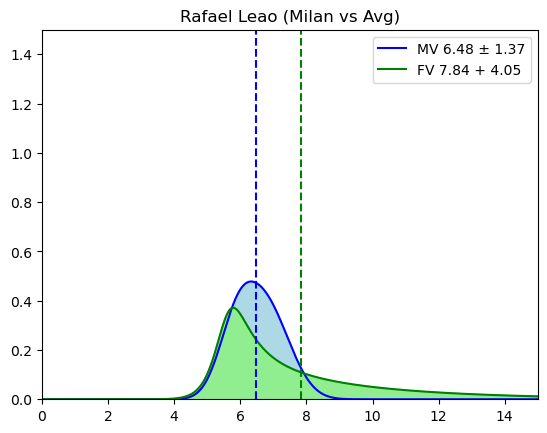

Rafael Leao: MV 6.48 ± 1.37; FV 7.84 + 4.05


[array([6.48351824, 7.84102121]),
 array([0.6832447, 2.0243561], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [56]:
predict_player('Rafael Leao', plot = 1, log = 1)

Tensorflow seems to have a custom definition for SinhArcsinh distribution. 

Here the code to generate the probability density function is reproduced.

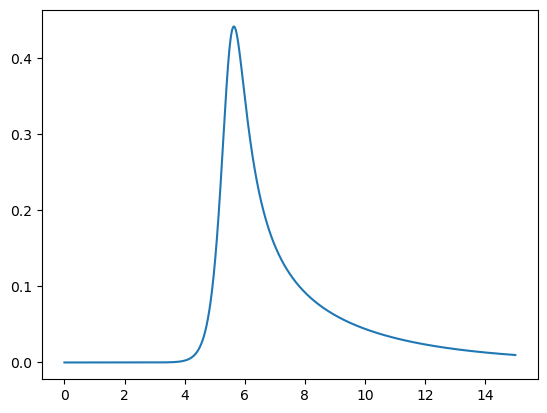

In [110]:
# custom franction to calculate the probability density function

def sinh_archsinh_pdf(x, mu, sigma, eps, delta):

    mul = np.sinh( np.arcsinh(2) * delta)
    
    mul = 2 / mul
    
    sigma_corr = sigma * mul
    
    z = (x - mu) / sigma_corr
    
    
    
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    
    f = np.exp(-0.5 * S * S)

    f /= np.sqrt(2 * np.pi)
    
    f *= 1 / ( sigma_corr * delta )
    
    f *= np.sqrt(1 + S * S)
    
    f /= np.sqrt(1 + z * z)
    
    return f
    

x = np.arange(start = 0, stop = 15, step = 0.001)


plt.plot(x, sinh_archsinh_pdf(x, 5.54, 1.4, 0.8, 1.68))


